In [2]:
from astropy.io import ascii
import matplotlib
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
import matplotlib.pyplot as plt   
import pandas as pd
import numpy as np
from dask.dataframe import from_pandas
import dask.bag as db
import dask_ml.datasets
import dask_ml.cluster
import dask.array as da
from dask.distributed import Client
import random
from pandas.plotting import scatter_matrix
import seaborn as sns


#Selecting a random column for sub-sampling
def select_feaure(data):
    return random.choice(data.columns)

def select_value(data,feature):
    min_split = data[feature].min()     #Min value of attribute 
    max_split = data[feature].max()     #Max value of attribute
    
    return (max_split-min_split)*np.random.random()+min_split       #Randomly selected split point from sequence
    

def split(data,split_column, split_value):
    data_above = data[data[split_column] > split_value]
    data_below = data[data[split_column] <= split_value]
   
    return data_above, data_below

def classify_data(data):
    
    label_column = data.values[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

def isolationTree(data, curHeight=0,heightLimit=50):
    if(curHeight>=heightLimit or len(data) <=1):
        classification = classify_data(data)
        
        return classification

    else:
        curHeight += 1

        split_attribute = select_feaure(data)       #Select feature
        split_value = select_value(data,split_attribute)   # Select Value to split on
        data_above, data_below = split(data,split_attribute,split_value)

        # Instantiate Subtree
        question = "{} <= {}".format(split_attribute,split_value)
        sub_tree = {question: []}

        # Recursive Logic
        below_answer = isolationTree(data_below,curHeight,heightLimit=heightLimit)
        above_answer = isolationTree(data_above,curHeight,heightLimit=heightLimit)

        if(below_answer == above_answer):
            sub_tree = below_answer

        else:
            sub_tree[question].append(below_answer)
            sub_tree[question].append(above_answer)

        return sub_tree

def isolationForest(data,numTrees,heightLimit, samplingSize):
    forest=[]

    for i in range(numTrees):
        if(samplingSize <=1):
            data = data.sample(frac=samplingSize)

        else:
            data = data.sample(samplingSize)

        tree = isolationTree(data,heightLimit=numTrees)
        forest.append(tree)
        
    return forest


def pathLength(data, tree,path=0):
    path = path + 1
    question = list(tree.keys())[0]
    feature_name, comparison_operator,value =  question.split()

    if data[feature_name].values <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    if(not isinstance(answer,dict)):
        return path
    
    else:
        residual_tree = answer
        return pathLength(data,residual_tree,path=path)

    return path
    
def evaluate_instance(instance,forest):
    paths = []
    for tree in forest:
        paths.append(pathLength(instance,tree))
        
    return paths
    
def c_factor(n) :
    """
    Average path length of unsuccesful search in a binary search     tree given n points
    
    Parameters
    ----------
    n : int
        Number of data points for the BST.
    Returns
    -------
    float
        Average path length of unsuccesful search in a BST
        
    """
    return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))
def anomaly_score(data_point,forest,n):
    '''
    Anomaly Score
    
    Returns
    -------
    ~0.5 -- sample does not have any distinct anomaly
    ~0 -- Normal Instance
    ~1 -- An anomaly
    '''
    # Mean depth for an instance
    E = np.mean(evaluate_instance(data_point,forest))
    
    c = c_factor(n)
    
    return 2**-(E/c)

In [3]:
from tqdm import tqdm
df = pd.read_csv('../data/data_scaled.csv')

# sns_plot = sns.pairplot(df.sample(1000),kind="scatter",diag_kind="kde")
# fig = sns_plot.fig

# scatter_matrix(df.sample(1000), alpha=0.2, figsize=(40, 40), diagonal='kde',cmap="#415BCB")
# fig.savefig("output.png")
# plt.show()

In [3]:
iForest = isolationForest(df,20, 150,512)
# outlier = evaluate_instance(X.head(1), iForest)
# normal = evaluate_instance(X.sample(1), iForest)
an= []
for i in tqdm(range(df.shape[0])):
    an.append(anomaly_score(df.iloc[[i]],iForest,512))

np.savetxt('iForestScores.dat',an, fmt='%.5f')

In [5]:
an = np.loadtxt('iForestScores.dat')
# # print(an)
# # Y=[[] for i in range(len(df))]
# file1 = open("Outliers.txt","a")
# outlier_index = []
# for i in tqdm(range(df.shape[0])):
#     if an[i] > 0.65:
#         outlier_index.append(i)
#         file1.write(str(i)+","+str(an[i])+"\n")
#         # x_val = df.iloc[i,0]
#         # y_val = df.iloc[i,1]
#         # Y[i] =[x_val,y_val]
# file1.close()

In [4]:
# Y = pd.DataFrame(Y, columns=["feat1","feat2"])
# Y = Y.dropna(axis=0)
# ax = df.plot.scatter(x='feat1',y='feat2',color='DarkBlue',label = 'Outliers')
# Y.plot.scatter(x='feat1',y='feat2',color='DarkGreen', label='Group 2',ax=ax)
# plt.figure(figsize=(7,7))
# plt.plot(x,y,'bo')
# Evaluate one instance

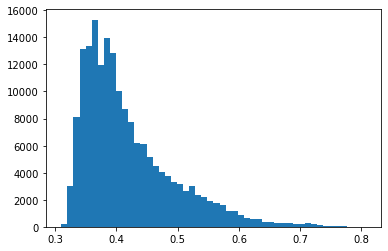

In [6]:
plt.hist(an, bins=50)
plt.show()


In [20]:
np.sum(np.array(an)>0.75)

113

In [8]:
np.sum(np.array(an)<0.365)

45610

In [21]:
from astropy.table import Table, Column
from stacker import stacker, ParStacker
tab = Table.read('../data/reduced_dr16q.fits')
# median spectrum out of all objects in the noise with label=1
FIBERID       = tab['FIBERID']
MJD           = tab['MJD']
PLATE         = tab['PLATE']
Z             = tab['Z']
mask_out_70 = (np.array(an)>0.7)
mask_out_72 = (np.array(an)>0.72)
mask_out_75 = (np.array(an)>0.75)
mask_in = (np.array(an)<0.365)
#label noise -1 (Noise of Noise)
MedSpeciForest_out_70 = stacker(Z[mask_out_70], PLATE[mask_out_70], MJD[mask_out_70], FIBERID[mask_out_70])
np.savetxt('MedSpeciForest_out_70.dat', MedSpeciForest_out_70)

MedSpeciForest_out_72 = stacker(Z[mask_out_72], PLATE[mask_out_72], MJD[mask_out_72], FIBERID[mask_out_72])
np.savetxt('MedSpeciForest_out_70.dat', MedSpeciForest_out_72)

MedSpeciForest_out_75 = stacker(Z[mask_out_75], PLATE[mask_out_75], MJD[mask_out_75], FIBERID[mask_out_75])
np.savetxt('MedSpeciForest_out_70.dat', MedSpeciForest_out_75)

100%|██████████| 971/971 [01:32<00:00, 10.47it/s]
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
100%|██████████| 519/519 [00:47<00:00, 10.84it/s]
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
100%|██████████| 113/113 [00:10<00:00, 10.59it/s]


In [10]:
MedSpeciForest_in = stacker(Z[mask_in], PLATE[mask_in], MJD[mask_in], FIBERID[mask_in])
np.savetxt('MedSpeciForest_in.dat', MedSpeciForest_in)

100%|██████████| 971/971 [01:21<00:00, 11.95it/s]
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
100%|██████████| 45610/45610 [1:06:49<00:00, 11.38it/s]


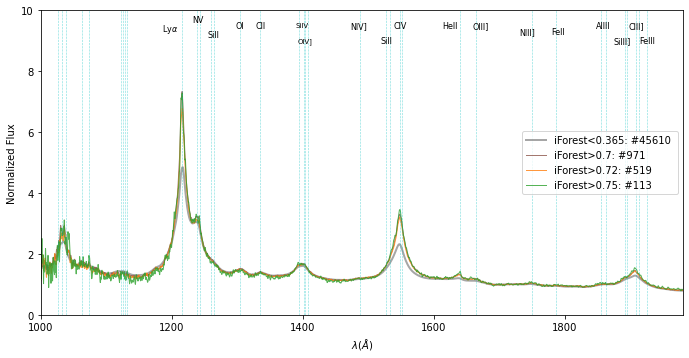

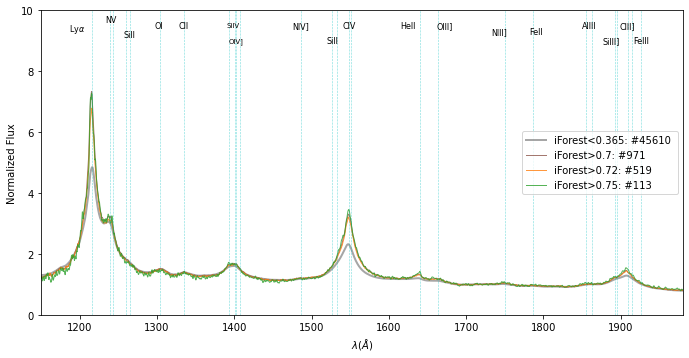

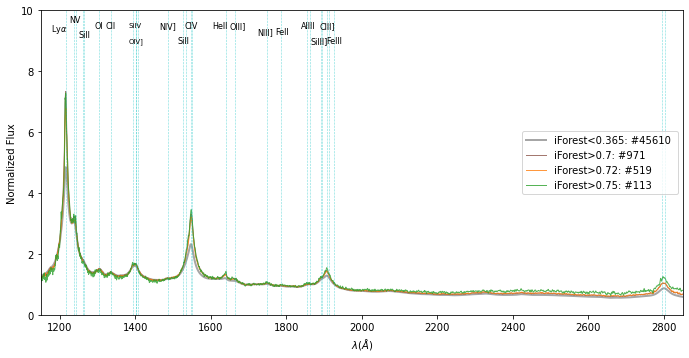

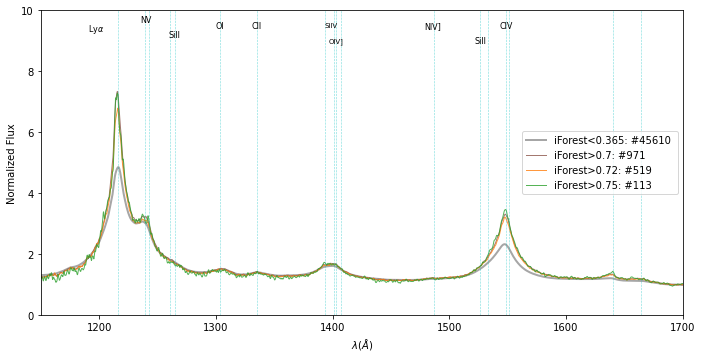

In [24]:
# Plotting Spectra -> REW

from scipy import ndimage
from line_db import line_db

c=['gray', 'C5', 'C1', 'C2', 'C3' , 'darkred']
ymax=10

ymin=0.02*ymax
fs=8
fs1=7
y_median = 0.95*ymax
med_step=.8
legend_loc=7

# -----------
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)

#  Median properties in each bin

for ii in range(4):

    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700


    SmoothedMedSpec_in = ndimage.filters.gaussian_filter1d(MedSpeciForest_in,2.0)
    SmoothedMedSpec_out_70 = ndimage.filters.gaussian_filter1d(MedSpeciForest_out_70,2.0)
    SmoothedMedSpec_out_72 = ndimage.filters.gaussian_filter1d(MedSpeciForest_out_72,2.0)
    SmoothedMedSpec_out_75 = ndimage.filters.gaussian_filter1d(MedSpeciForest_out_75,2.0)
    
      
    # masking for plot ranges
    ind = (wgrid>lambda_min) & (wgrid<lambda_max)
    
    #plotting
    fig = plt.figure(figsize=(11.5,5.6))
    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    plt.ylabel('Normalized Flux')
    plt.xlabel(r'$\lambda  (\AA)$')
    x_median=lambda_min+200
    plt.plot(wgrid[ind],  SmoothedMedSpec_in[ind], c=c[0], label = 'iForest<0.365: #%d '%(sum(mask_in)), lw=2, alpha=0.7)
    plt.plot(wgrid[ind],  SmoothedMedSpec_out_70[ind], c=c[1], label = 'iForest>0.7: #%d'    %(sum(mask_out_70)), lw=1, alpha=0.8)
    plt.plot(wgrid[ind],  SmoothedMedSpec_out_72[ind], c=c[2], label = 'iForest>0.72: #%d'    %(sum(mask_out_72)), lw=1, alpha=0.8)
    plt.plot(wgrid[ind],  SmoothedMedSpec_out_75[ind], c=c[3], label = 'iForest>0.75: #%d'    %(sum(mask_out_75)), lw=1, alpha=0.8)
    
    plt.legend(loc=7)
    line_db(ymax, fs, fs1, ii) 
    fig_path = 'med-spec-%d-%d-iForest.png'%(lambda_min, lambda_max)
    plt.savefig(fig_path, format='png', dpi=800, bbox_inches='tight')
    plt.show()


